In [1]:
import warnings
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from sklearn.preprocessing import StandardScaler
from core.tools.create_submission import create_submission
from math import ceil

warnings.filterwarnings("ignore")

def load_and_prepare_data():
    df = pd.read_csv("frames_errors.csv", header=None)
    
    df.columns = [
        "block_id", "frame_idx", "E_mu_Z", "E_mu_phys_est", "E_mu_X", "E_nu1_X", "E_nu2_X", 
        "E_nu1_Z", "E_nu2_Z", "N_mu_X", "M_mu_XX", "M_mu_XZ", "M_mu_X", "N_mu_Z", "M_mu_ZZ", 
        "M_mu_Z", "N_nu1_X", "M_nu1_XX", "M_nu1_XZ", "M_nu1_X", "N_nu1_Z", "M_nu1_ZZ", 
        "M_nu1_Z", "N_nu2_X", "M_nu2_XX", "M_nu2_XZ", "M_nu2_X", "N_nu2_Z", "M_nu2_ZZ", 
        "M_nu2_Z", "nTot", "bayesImVoltage", "opticalPower", "polarizerVoltages[0]", 
        "polarizerVoltages[1]", "polarizerVoltages[2]", "polarizerVoltages[3]", "temp_1", 
        "biasVoltage_1", "temp_2", "biasVoltage_2", "synErr", "N_EC_rounds", "maintenance_flag", 
        "estimator_name", "f_EC", "E_mu_Z_est", "R", "s", "p"
    ]
    
    df_base = df.drop(["E_mu_phys_est"], axis=1)

    return df_base

def create_features(df: pd.DataFrame):
    """Создание расширенных признаков"""
    df_featured = df.copy()
    
    # Основные QBER признаки
    df_featured['E_mu_avg'] = (df_featured['E_mu_Z'] + df_featured['E_mu_X']) / 2
    df_featured['E_mu_diff'] = df_featured['E_mu_Z'] - df_featured['E_mu_X']
    
    # Статистики по состояниям
    df_featured['total_sent'] = df_featured[['N_mu_X', 'N_mu_Z']].sum(axis=1)
    df_featured['mu_ratio'] = (df_featured['N_mu_X'] + df_featured['N_mu_Z']) / (df_featured['total_sent'] + 1e-8)
    
    # Физические параметры
    df_featured['temp_avg'] = (df_featured['temp_1'] + df_featured['temp_2']) / 2
    df_featured['bias_avg'] = (df_featured['biasVoltage_1'] + df_featured['biasVoltage_2']) / 2
    
    # Скользящие статистики (очень полезны!)
    df_featured['E_mu_Z_rolling_mean_10'] = df_featured.groupby('block_id')['E_mu_Z'].transform(lambda x: x.rolling(10, min_periods=1).mean())
    df_featured['E_mu_Z_rolling_std_10'] = df_featured.groupby('block_id')['E_mu_Z'].transform(lambda x: x.rolling(10, min_periods=1).std().fillna(0))

    # Изменение температуры
    df_featured['temp_1_diff'] = df_featured.groupby('block_id')['temp_1'].diff().fillna(0)

    return df_featured

def prepare_time_series_data(df: pd.DataFrame, target_column='E_mu_Z', sequence_length=160, horizon=8):
    """Подготовка данных для временных рядов"""
    
    # Переименование
    df = df.rename(columns={"block_id": "id", "frame_idx": "date", target_column: "value"})
    
    # Выбор признаков
    #feature_columns = [
    #    'value', 'E_mu_X', 'E_nu1_Z', 'E_nu2_Z', 'temp_1',
    #    'temp_2', 'biasVoltage_1', 'biasVoltage_2', 'E_mu_diff',
    #    'polarizerVoltages[0]', 'polarizerVoltages[1]', 'polarizerVoltages[2]', 'polarizerVoltages[3]',
    #    'bayesImVoltage', 'synErr', 'N_EC_rounds', 'E_mu_Z_rolling_mean_10', 'E_mu_Z_rolling_std_10'
    #    'total_sent', 'temp_avg', 'bias_avg', 'opticalPower', 'temp_1_diff'
    #]

    # Эти признаки — **реально полезны**
    feature_columns = [
        # QBER-признаки (основа)
        'value',        # ← целевая переменная (только для обучения!)
        'E_mu_X',
        'E_nu1_Z',
        'E_nu2_Z',

        # Температуры
        'temp_1',
        'temp_2',

        # Напряжения
        'biasVoltage_1',
        'biasVoltage_2',

        # Напряжения поляризаторов
        'polarizerVoltages[0]',
        'polarizerVoltages[1]',
        'polarizerVoltages[2]',
        'polarizerVoltages[3]',

        # Оптические параметры
        'opticalPower',
        'bayesImVoltage',

        # Индикаторы ошибок
        'synErr',
        'N_EC_rounds',

        # Коэффициент избыточности (переменный!)
        'f_EC',

        # Индикатор обслуживания
        'maintenance_flag'
    ]
    existing_features = [col for col in feature_columns if col in df.columns]
    
    # Создание датафрейма с выбранными признаками
    df_for_ts = df[['id', 'date'] + existing_features].dropna(subset=['value'], how='any')
    
    # Обработка временных рядов
    df_for_ts = df_for_ts.set_index(['id', 'date']).unstack().ffill().stack().reset_index()
    df_for_ts = df_for_ts.groupby('id').filter(lambda x: len(x) == 400)
    
    return df_for_ts, existing_features

In [2]:
class TimeSeriesDataset(Dataset):
    """Кастомный Dataset для временных рядов"""
    
    def __init__(self, data, sequence_length=160, horizon=8, target_col='value', scale=True):
        self.data = data
        self.sequence_length = sequence_length
        self.horizon = horizon
        self.target_col = target_col
        self.scale = scale
        
        self.groups = []
        self.scalers = {}
        
        for device_id in data['id'].unique():
            device_data = data[data['id'] == device_id].sort_values('date')
            
            feature_cols = [col for col in device_data.columns if col not in ['id', 'date', target_col]]
            features = device_data[feature_cols].values
            target = device_data[target_col].values
            
            if scale:
                feature_scaler = StandardScaler()
                target_scaler = StandardScaler()
                
                features_scaled = feature_scaler.fit_transform(features)
                target_scaled = target_scaler.fit_transform(target.reshape(-1, 1)).flatten()
                
                self.scalers[device_id] = (feature_scaler, target_scaler)
            else:
                features_scaled = features
                target_scaled = target
                self.scalers[device_id] = (None, None)
            
            sequences = []
            targets = []
            
            for i in range(len(device_data) - sequence_length - horizon + 1):
                seq_features = features_scaled[i:i + sequence_length]
                seq_target = target_scaled[i + sequence_length:i + sequence_length + horizon]
                
                sequences.append(seq_features)
                targets.append(seq_target)
            
            if sequences:
                self.groups.append({
                    'device_id': device_id,
                    'sequences': np.array(sequences, dtype=np.float32),
                    'targets': np.array(targets, dtype=np.float32)
                })

        self.all_sequences = np.concatenate([group['sequences'] for group in self.groups])
        self.all_targets = np.concatenate([group['targets'] for group in self.groups])
    
    def __len__(self):
        return len(self.all_sequences)
    
    def __getitem__(self, idx):
        sequence = self.all_sequences[idx] 
        target = self.all_targets[idx]      
        
        sequence_tensor = torch.FloatTensor(sequence)
        target_tensor = torch.FloatTensor(target)
        
        return sequence_tensor, target_tensor


In [ ]:
from core.tools.metrics import *
import torch
import torch.nn as nn
import torch.optim as optim
from torch.amp import GradScaler, autocast
import sys

def calculate_secret_key_length(corrected_key_length: int, 
                               reconciliation_info: int, 
                               privacy_amplification_loss: int) -> int:
    """
    Вычисляет длину секретного ключа.
    """
    secret_key_length = max(0, corrected_key_length - reconciliation_info - privacy_amplification_loss)
    return secret_key_length

def quantile_loss(y_true, y_pred, q=0.95):  # ↑ до 0.95!
    e = y_true - y_pred
    return torch.mean(torch.max(q * e, (q - 1) * e))

def compute_qkd_metrics(corrected_keys: list, reconciliation_infos: list, privacy_losses: list) -> dict:
    """
    Вычисляет QKD метрики: Public и Private.
    corrected_keys: [len1, len2, len3, len4, len5] — длины после коррекции
    reconciliation_infos: [info1, info2, ...]
    privacy_losses: [loss1, loss2, ...]
    """
    # Public metric: на 2 фиксированных сегментах
    public_metric = 0
    for i in range(2):
        sk_len = calculate_secret_key_length(
            corrected_key_length=corrected_keys[i],
            reconciliation_info=reconciliation_infos[i],
            privacy_amplification_loss=privacy_losses[i]
        )
        public_metric += sk_len

    # Private metric: на всех 5 сегментах
    private_metric = 0
    for i in range(5):
        sk_len = calculate_secret_key_length(
            corrected_key_length=corrected_keys[i],
            reconciliation_info=reconciliation_infos[i],
            privacy_amplification_loss=privacy_losses[i]
        )
        private_metric += sk_len

    return {
        "public_metric": public_metric,
        "private_metric": private_metric
    }

def train_model(model: nn.Module, train_loader, val_loader, device, epochs=10, lr=1e-3):
    """Обучение модели с QKD метриками: public и private secret key length."""
    
    criterion = nn.SmoothL1Loss()
    optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=1e-4)
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, patience=3, factor=0.5)
    
    scaler = GradScaler("cuda")

    train_losses = []
    val_losses = []
    
    # Метрики QKD
    train_public_metrics = []
    val_public_metrics = []
    train_private_metrics = []
    val_private_metrics = []
    
    best_private_metric = -float('inf')
    patience = 50
    patience_counter = 0
    
    sample_batch = next(iter(train_loader))
    sequence_length = sample_batch[0].shape[1]
    decoding_complexity = calculate_decoding_complexity(model, sequence_length)
    
    print(f"Decoding Complexity Metrics:")
    print(f"  Total Parameters: {decoding_complexity['total_parameters']:,}")
    print(f"  Computational Complexity: {decoding_complexity['computational_complexity']:,}")
    print(f"  Complexity Score: {decoding_complexity['complexity_score']:,}")
    
    try:
        model.load_state_dict(torch.load('best_model.pth'))
        print("Use the best_model.pth")
    except:
        print("Already started train a new model")
        
    for epoch in range(epochs):

        if epoch == 0:
            with torch.no_grad():
                sample_seq, sample_tgt = next(iter(train_loader))
                sample_seq = sample_seq.to(device)
                sample_out = model(sample_seq)
                print(f"Initial model output shape: {sample_out.shape}")
                print(f"Initial output mean: {sample_out.mean().item():.6f}, std: {sample_out.std().item():.6f}")
                print(f"Sample target mean: {sample_tgt.mean().item():.6f}, std: {sample_tgt.std().item():.6f}")
        # Обучение
        model.train()
        train_loss = 0.0
        train_public_metric = 0.0
        train_private_metric = 0.0
        
        for sequences, targets in train_loader:
            sequences = sequences.to(device)
            targets = targets.to(device)
            
            optimizer.zero_grad()
            
            with autocast("cuda", dtype=torch.float16):
                outputs = model(sequences)
                predictions = outputs[:, :, 0]
                loss = criterion(predictions, targets)

            scaler.scale(loss).backward()
            scaler.step(optimizer)
            scaler.update()
            
            train_loss += loss.item()
            
            # Дискретизация: предполагаем, что > 0.5 = 1, иначе = 0
            pred_bits = (predictions > 0.5).float()
            target_bits = (targets > 0.5).float()
            
            # Вычисляем QKD метрики для батча (псевдо-сегменты)
            with torch.no_grad():
                corrected_key_length = int(torch.sum((pred_bits == target_bits).float()).item())
                
                # Пример: на основе длины ключа вычисляем метрики
                corrected_keys = [corrected_key_length] * 5  # 5 сегментов
                reconciliation_infos = [50] * 5  # пример
                privacy_losses = [20] * 5       # пример
                qkd_metrics = compute_qkd_metrics(corrected_keys, reconciliation_infos, privacy_losses)
                
                train_public_metric += qkd_metrics["public_metric"]
                train_private_metric += qkd_metrics["private_metric"]
        
        model.eval()
        val_loss = 0.0
        val_public_metric = 0.0
        val_private_metric = 0.0
        
        with torch.no_grad():
            for sequences, targets in val_loader:
                sequences = sequences.to(device)
                targets = targets.to(device)
                
                outputs = model(sequences)
                predictions = outputs[:, :, 0]
                
                loss = criterion(predictions, targets)
                val_loss += loss.item()
                
                # Дискретизация
                pred_bits = (predictions > 0.5).float()
                target_bits = (targets > 0.5).float()
                
                corrected_key_length = int(torch.sum((pred_bits == target_bits).float()).item())
                
                corrected_keys = [corrected_key_length] * 5
                reconciliation_infos = [50] * 5
                privacy_losses = [20] * 5
                qkd_metrics = compute_qkd_metrics(corrected_keys, reconciliation_infos, privacy_losses)
                
                val_public_metric += qkd_metrics["public_metric"]
                val_private_metric += qkd_metrics["private_metric"]
        
        train_loss /= len(train_loader)
        val_loss /= len(val_loader)
        train_public_metric /= len(train_loader)
        val_public_metric /= len(val_loader)
        train_private_metric /= len(train_loader)
        val_private_metric /= len(val_loader)
        
        train_losses.append(train_loss)
        val_losses.append(val_loss)
        train_public_metrics.append(train_public_metric)
        val_public_metrics.append(val_public_metric)
        train_private_metrics.append(train_private_metric)
        val_private_metrics.append(val_private_metric)
        
        scheduler.step(val_loss)
        
        # Early stopping по private metric
        if val_loss < best_private_metric:
            best_private_metric = val_loss
            patience_counter = 0
            torch.save(model.state_dict(), 'best_model.pth')
        else:
            patience_counter += 1
        
        print(f'Epoch {epoch+1}/{epochs}:')
        print(f'  Train Loss: {train_loss:.6f}, Val Loss: {val_loss:.6f}')
        print(f'  Train Public Metric: {ceil(train_public_metric * 100) + ceil(train_private_metric * 100):,}, Val Public Metric: {ceil(val_public_metric * 100) + ceil(val_private_metric * 100):,}')
        print(f'  LR: {optimizer.param_groups[0]["lr"]:.2e} | Patience Counter: {patience_counter}')
        
        if patience_counter >= patience:
            print(f'Early stopping at epoch {epoch+1}')
            break
    
    return model, train_losses, val_losses

def predict(model, test_loader, device):
    """Прогнозирование на тестовых данных"""
    model.eval()
    predictions = []
    
    with torch.no_grad():
        for sequences, targets in test_loader:
            sequences = sequences.to(device)
            
            outputs = model(sequences)
            preds = outputs[:, :, 0].cpu().numpy()
            
            predictions.extend(preds)
    
    return np.array(predictions)

In [ ]:
from model import DLinear_NN

SEQUENCE_LENGTH = 160
HORIZON = 8
BATCH_SIZE = 1280
EPOCHS = 500
LEARNING_RATE = 0.001

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

df = load_and_prepare_data()
df = create_features(df)
df_for_ts, feature_columns = prepare_time_series_data(df)

device_ids = df_for_ts['id'].unique()
train_devices = device_ids[:int(0.7 * len(device_ids))]
val_devices = device_ids[int(0.7 * len(device_ids)):int(0.85 * len(device_ids))]
test_devices = device_ids[int(0.85 * len(device_ids)):]

train_data = df_for_ts[df_for_ts['id'].isin(train_devices)]
val_data = df_for_ts[df_for_ts['id'].isin(val_devices)]
test_data = df_for_ts[df_for_ts['id'].isin(test_devices)]

#  print(f"{train_data.shape = } | {val_data.shape = } | {test_data.shape = }")

train_dataset = TimeSeriesDataset(train_data, SEQUENCE_LENGTH, HORIZON)
val_dataset = TimeSeriesDataset(val_data, SEQUENCE_LENGTH, HORIZON)
test_dataset = TimeSeriesDataset(test_data, SEQUENCE_LENGTH, HORIZON)

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

# Модель
num_features = len(feature_columns) - 1
model = DLinear_NN(
    pred_len=HORIZON,        
    seq_len=SEQUENCE_LENGTH,       
    num_features=num_features,
).to(device)

for param in model.parameters():
    param.requires_grad = True

print(f"Количество параметров: {sum(p.numel() for p in model.parameters())}")

for i in range(5):
    model, train_losses, val_losses = train_model(
        model, train_loader, val_loader, device, EPOCHS, LEARNING_RATE
    )

model.load_state_dict(torch.load("best_model.pth"))

print("3. Прогнозирование...")
test_predictions = predict(model, test_loader, device)

test_predictions_original = []
for i, device_id in enumerate(test_devices):
    if device_id in test_dataset.scalers:
        _, target_scaler = test_dataset.scalers[device_id]
        if target_scaler:
            device_preds = test_predictions[i * (400 - SEQUENCE_LENGTH - HORIZON + 1): 
                                            (i + 1) * (400 - SEQUENCE_LENGTH - HORIZON + 1)]
            last_preds = device_preds[:, -1].reshape(-1, 1)
            original_scale = target_scaler.inverse_transform(last_preds).flatten()
            test_predictions_original.extend(original_scale)

print("4. Создание submission...")
create_submission(test_predictions_original)

print("Готово!")

Количество параметров: 2576
Decoding Complexity Metrics:
  Total Parameters: 2,576
  Computational Complexity: 412,160
  Complexity Score: 414,736
Already started train a new model
Initial model output shape: torch.Size([1280, 8, 17])
Initial output mean: 0.009144, std: 0.431891
Sample target mean: -0.002638, std: 0.975354
Epoch 1/500:
  Train Loss: 0.378089, Val Loss: 0.352420
  Train Public Metric: 5,189,323, Val Public Metric: 5,114,597
  LR: 1.00e-03 | Patience Counter: 0
Epoch 2/500:
  Train Loss: 0.336431, Val Loss: 0.349046
  Train Public Metric: 5,376,223, Val Public Metric: 5,130,331
  LR: 1.00e-03 | Patience Counter: 1
Epoch 3/500:
  Train Loss: 0.335542, Val Loss: 0.349130
  Train Public Metric: 5,380,564, Val Public Metric: 5,134,380
  LR: 1.00e-03 | Patience Counter: 2
Epoch 4/500:
  Train Loss: 0.335569, Val Loss: 0.349586
  Train Public Metric: 5,382,557, Val Public Metric: 5,130,909
  LR: 1.00e-03 | Patience Counter: 3
Epoch 5/500:
  Train Loss: 0.335510, Val Loss: 0.34

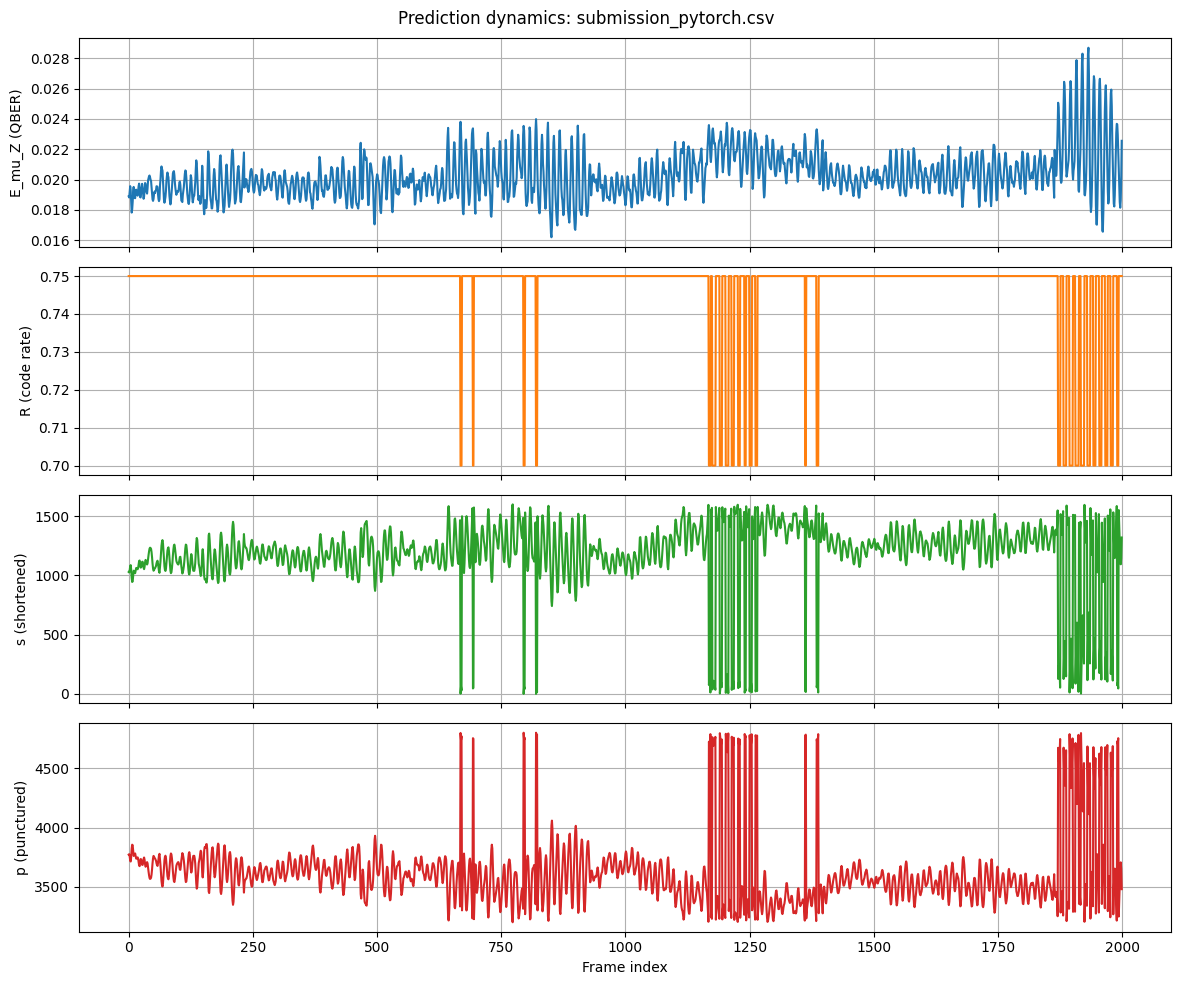

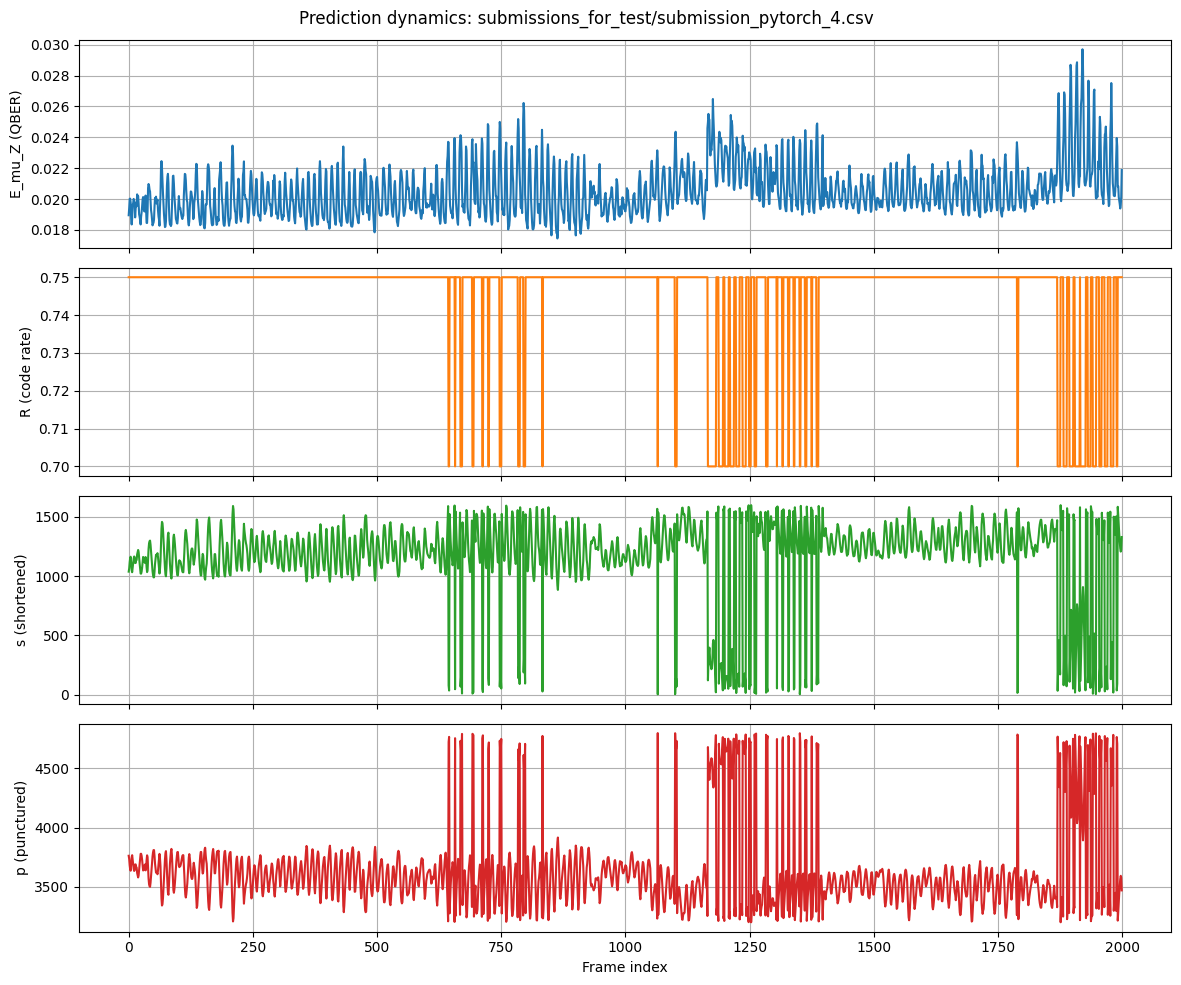

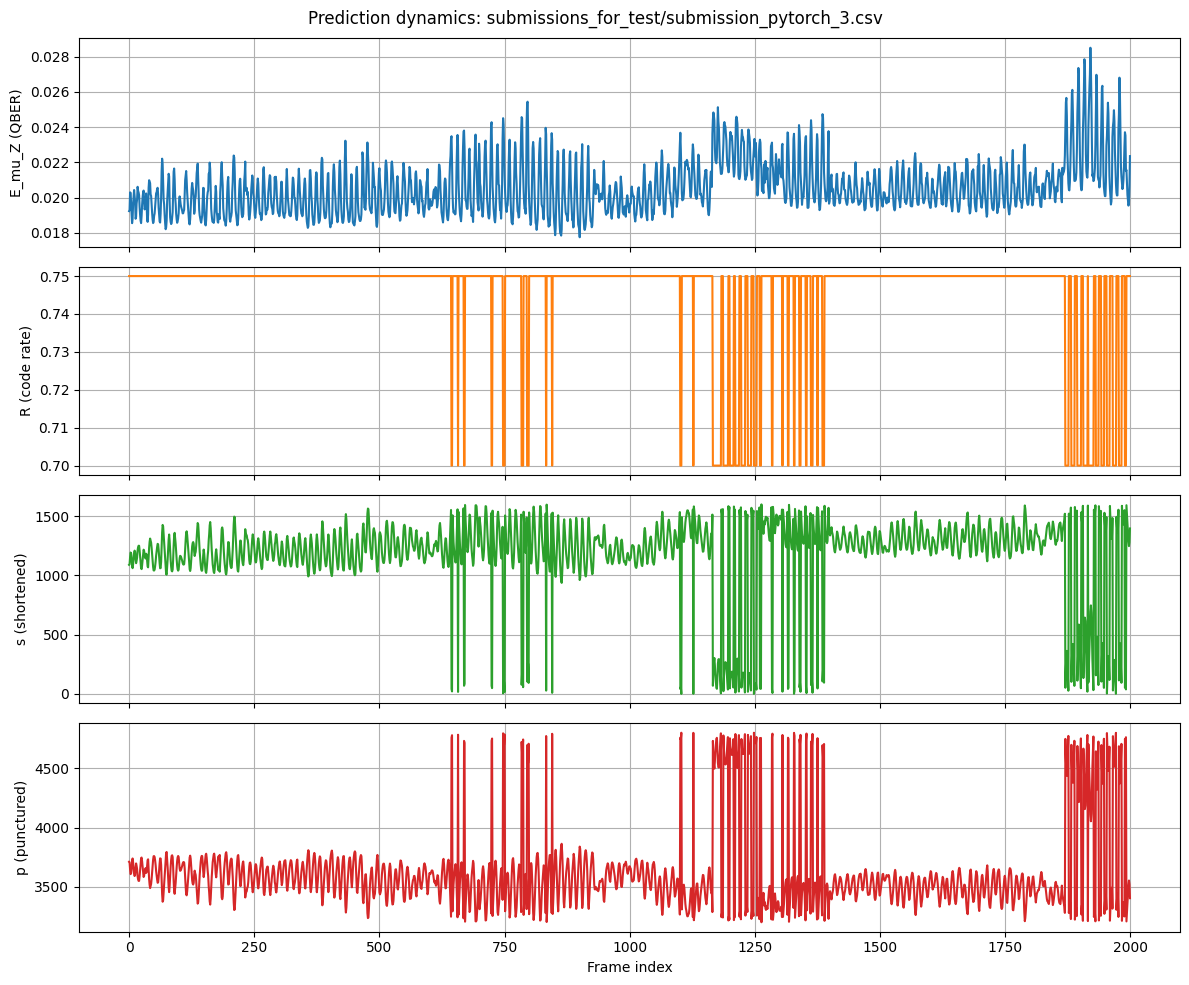

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd

def show_graphics(file_csv: str):
    df = pd.read_csv(file_csv, header=None)
    df.columns = ["E_mu_Z", "R", "s", "p"]
    
    fig, axs = plt.subplots(4, 1, figsize=(12, 10), sharex=True)
    fig.suptitle(f'Prediction dynamics: {file_csv}')
    
    x = range(len(df))  # номер фрейма (0, 1, 2, ..., 1999)
    
    axs[0].plot(x, df["E_mu_Z"], color='tab:blue')
    axs[0].set_ylabel('E_mu_Z (QBER)')
    axs[0].grid(True)
    
    axs[1].plot(x, df["R"], color='tab:orange')
    axs[1].set_ylabel('R (code rate)')
    axs[1].grid(True)
    
    axs[2].plot(x, df["s"], color='tab:green')
    axs[2].set_ylabel('s (shortened)')
    axs[2].grid(True)
    
    axs[3].plot(x, df["p"], color='tab:red')
    axs[3].set_ylabel('p (punctured)')
    axs[3].set_xlabel('Frame index')
    axs[3].grid(True)
    
    plt.tight_layout()
    plt.show()

show_graphics("submission_pytorch.csv")
show_graphics("submissions_for_test/submission_pytorch_4.csv")
show_graphics("submissions_for_test/submission_pytorch_3.csv")


In [ ]:
import numpy as np
import pandas as pd
from midiutil import MIDIFile

df = pd.read_csv("submission_pytorch.csv", header=None)
df.columns = ["E_mu_Z", "R", "s", "p"]

def data_to_rap_beat(df, filename="submission_rap_beat.mid"):
    midi = MIDIFile(2)  # 2 дорожки: 1 - бит, 2 - рифмы
    track = 0
    time = 0
    midi.addTrackName(track, time, "Rap Beat")
    midi.addTempo(track, time, 120)

    # Дорожка 0: бит
    for idx, row in df.iterrows():
        # Бас-бочка при низком R (< 0.72)
        if row["R"] < 0.72:
            midi.addNote(track, 0, 35, time, 0.25, 100)  # Kick drum
        # Клик при изменении s
        if idx > 0 and abs(row["s"] - df.iloc[idx - 1]["s"]) > 100:
            midi.addNote(track, 0, 37, time, 0.1, 80)  # Snare

        # Свист при высоком p (> 4000)
        if row["p"] > 4000:
            midi.addNote(track, 0, 76, time, 0.5, 70)  # Whistle

        time += 0.25

    # Дорожка 1: рифмы (E_mu_Z → нота)
    track = 1
    time = 0
    for idx, row in df.iterrows():
        # Нота в зависимости от E_mu_Z
        note = 50 + int(row["E_mu_Z"] * 100)  # Пример: 0.020 → нота 52
        volume = 60 + int(row["s"] / 4800 * 64)
        midi.addNote(track, 0, note, time, 0.25, volume)
        time += 0.25

    # Сохраняем
    with open(filename, "wb") as file:
        midi.writeFile(file)

    print(f"Реп-бит сохранён в {filename}")

data_to_rap_beat(df)

SyntaxError: invalid syntax (1961048262.py, line 32)